<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Modules" data-toc-modified-id="Import-Modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Modules</a></span><ul class="toc-item"><li><span><a href="#General-Modules" data-toc-modified-id="General-Modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General Modules</a></span></li><li><span><a href="#Tensorflow" data-toc-modified-id="Tensorflow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tensorflow</a></span></li></ul></li><li><span><a href="#Model-Class" data-toc-modified-id="Model-Class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Class</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Key-Layer-Names-of-Pretrained-Models" data-toc-modified-id="Key-Layer-Names-of-Pretrained-Models-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Key Layer Names of Pretrained Models</a></span></li></ul></li><li><span><a href="#Model-Units" data-toc-modified-id="Model-Units-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Units</a></span></li><li><span><a href="#UNET" data-toc-modified-id="UNET-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>UNET</a></span></li></ul></li><li><span><a href="#Initialize" data-toc-modified-id="Initialize-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initialize</a></span><ul class="toc-item"><li><span><a href="#Environment-Setup" data-toc-modified-id="Environment-Setup-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Environment Setup</a></span></li><li><span><a href="#Initial-Parameters" data-toc-modified-id="Initial-Parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Initial Parameters</a></span></li><li><span><a href="#Model-Setup" data-toc-modified-id="Model-Setup-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Model Setup</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Build Model</a></span></li></ul></li><li><span><a href="#Prepare-Data-And-Calculate" data-toc-modified-id="Prepare-Data-And-Calculate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare Data And Calculate</a></span><ul class="toc-item"><li><span><a href="#Load-File-Names" data-toc-modified-id="Load-File-Names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load File Names</a></span></li></ul></li></ul></div>

## Import Modules

### General Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import platform
import datetime
import pandas as pd
import pickle
import shutil
import importlib
import os
import glob

### Tensorflow

In [2]:
import tensorflow as tf
from keras.utils import io_utils, tf_utils
from tensorflow.keras import (layers, models,
                              utils, optimizers,
                              callbacks, regularizers,
                              losses, activations,
                              applications)
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

## Model Class

#### Key Layer Names of Pretrained Models

In [3]:
imported_layers = {
    'EfficientNetB0': ['block2a_expand_activation',
                       'block3a_expand_activation',
                       'block4a_expand_activation',
                       'block6a_expand_activation',
                       'top_activation'],
    'MobileNetV2': ['block_1_expand_relu',
                    'block_3_expand_relu',
                    'block_6_expand_relu',
                    'block_13_expand_relu',
                    'out_relu'],
    'EfficientNetV2B2': ['block1b_add',
                         'block2c_add',
                         'block4a_expand_activation',
                         'block6a_expand_activation',
                         'top_activation'],
    'EfficientNetV2S': ['block1b_add',
                         'block2d_add',
                         'block3d_add',
                         'block5i_add',
                         'top_activation'],
    'ResNet101V2': ['conv1_conv',
                    'conv2_block2_out',
                    'conv3_block3_out',
                    'conv4_block22_out',
                    'post_relu'],
    'ResNet50V2': ['conv1_conv',
                   'conv2_block3_1_relu',
                   'conv3_block4_1_relu',
                   'conv4_block6_1_relu',
                   'post_relu'],
    'DenseNet201': ['conv1/relu',
                    'pool2_conv',
                    'pool3_conv',
                    'pool4_conv',
                    'relu'],
    'VGG16': ['block2_conv2',
              'block3_conv3',
              'block4_conv3',
              'block5_conv3',
              'block5_pool']
}

### Model Units

In [4]:
class UNET_units():
    def __init__(self, 
                 layer_normalization=True,
                 batch_normalization=True):
        self.layer_normalization=layer_normalization
        self.batch_normalization=batch_normalization

    def normalization(self, l):
        if self.batch_normalization:
            l = layers.BatchNormalization()(l)
        if self.layer_normalization:
            l = layers.LayerNormalization()(l)        
        return l
    
    def AverageAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_mean(input_layer, axis=axis)
        l = input_layer
        return l

    def MaxAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_max(input_layer, axis=axis)
        l = input_layer
        return l
    
    def repeat_element(self, input_layer, rep):
        l = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=-1),
                            arguments = {'repnum':rep})(input_layer)
        return l

    def LSTM_block(self, input_layer, dropout_factor, L2_factor, axis=3, t_now=4):
        l = tf.transpose(input_layer, perm=[0, 3, 1, 2, 4])

        l_now = self.ExpandDimension(l[:, t_now, :, :, :], axis=1)

        l_forward = layers.ConvLSTM2D(l.get_shape()[-1], kernel_size=[3, 3], padding='same',
                                      kernel_regularizer=regularizers.L2(
                                          L2_factor),
                                      dropout=dropout_factor, recurrent_dropout=dropout_factor)(l[:, 0:t_now, :, :, :])
        l_forward = self.ExpandDimension(l_forward, axis=1)

        l_backward = layers.ConvLSTM2D(l.get_shape()[-1], kernel_size=[3, 3], padding='same',
                                       kernel_regularizer=regularizers.L2(
                                           L2_factor),
                                       dropout=dropout_factor, recurrent_dropout=dropout_factor)(l[:, l.shape[1]-1:t_now:-1, :, :, :])
        l_backward = self.ExpandDimension(l_backward, axis=1)

        l = layers.concatenate([l_now, l_forward, l_backward], axis=1)
        l = tf.transpose(l, perm=[0, 2, 3, 4, 1])

        l = layers.Conv3D(
            1, [1, 1, 1], kernel_regularizer=regularizers.L2(L2_factor))(l)
        l = tf.reduce_max(l, axis=4)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        # l = layers.Activation(activations.relu)(l)
        return l

    def Transformer_block(self, input_layer, dropout_factor, L2_factor):
        def Feed_Forward_cell(l):
            l = tf.transpose(l, perm=[0, 3, 1, 2, 4])
            l = layers.Conv2D(l.shape[-1], [3, 3], input_shape=l.shape[2:], padding='same',
                              kernel_regularizer=regularizers.L2(L2_factor),
                              dropout=dropout_factor)(l)
            l = activations.relu(l)
            l = layers.Conv2D(l.shape[-1], [3, 3], input_shape=l.shape[2:], padding='same',
                              kernel_regularizer=regularizers.L2(L2_factor),
                              dropout=dropout_factor)(l)
            l = tf.transpose(l, perm=[0, 2, 3, 1, 4])
            return l

        def AddAndNorm(l, c):
            l = l + c
            l = layers.LayerNormalization()(l)
            return l

        c1 = input_layer
        l = layers.MultiHeadAttention(
            num_heads=2, key_dim=2, attention_axes=(3,))(input_layer, input_layer)
        l = AddAndNorm(l, c1)
        c2 = l
        l = Feed_Forward_cell(l)
        l = AddAndNorm(l, c2)
        l = layers.AveragePooling3D((1, 1, l.shape[3]))(l)
        l = tf.squeeze(l)
        return l

    def ExpandDimension(self, input_layer, axis=3):
        shape = (-1,)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        for i in range(1, input_dim):
            if not i == axis:
                shape += (input_shape[i],)
            else:
                shape += (1,)
                shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l

    def AttentionGate(self, input_layer, query_layer, dropout_factor, L2_factor, F_int=128):
        if len(input_layer.shape) == 5:
            stride_factor_xy = int(input_layer.shape[1]/query_layer.shape[1])
            stride_factor_z = int(input_layer.shape[3]/query_layer.shape[3])
            Conv = layers.Conv3D
            kernel_size = [1, 1, 1]
            strides = [stride_factor_xy, stride_factor_xy, stride_factor_z]
            Up = layers.UpSampling3D(size=strides)
        elif len(input_layer.shape) == 4:
            stride_factor_xy = int(input_layer.shape[1]/query_layer.shape[1])
            Conv = layers.Conv2D
            kernel_size = [1, 1]
            strides = [stride_factor_xy, stride_factor_xy]
            Up = layers.UpSampling2D(size=strides)

        x1 = Conv(F_int, kernel_size=kernel_size, strides=strides,
                  kernel_regularizer=regularizers.l2(L2_factor))(input_layer)
        q1 = Conv(F_int, kernel_size=kernel_size,
                  kernel_regularizer=regularizers.l2(L2_factor))(query_layer)

        x1 = layers.Add()([x1, q1])
        x1 = self.normalization(x1)
        x1 = layers.Activation(activations.relu)(x1)
        x1 = layers.Dropout(dropout_factor)(x1)

        x1 = Conv(1, kernel_size=kernel_size,
                  kernel_regularizer=regularizers.l2(L2_factor))(x1)
        x1 = self.normalization(x1)
        x1 = layers.Activation(activations.sigmoid)(x1)
        x1 = layers.Dropout(dropout_factor)(x1)

        x1 = Up(x1)
        x1 = self.repeat_element(x1, input_layer.shape[-1])
        output = layers.Multiply()([x1, input_layer])
        output = self.normalization(output)
        return output

    def Depth_conv_cell(self, input_layer, dropout_factor, L2_factor,
                        depth_kernel_size=3, filters=32, padding='same'):
        l = layers.Conv3D(kernel_size=[1, 1, depth_kernel_size], filters=filters,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding=padding)(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        return l

    def Channel_FC_cell(self, input_layer, dropout_factor, L2_factor):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 4:
            l = layers.Conv2D(kernel_size=[1, 1], filters=input_shape[-1],
                              kernel_regularizer=regularizers.l2(L2_factor),
                              padding='same')(input_layer)
        elif input_dim == 5:
            l = layers.Conv3D(kernel_size=[1, 1, 1], filters=input_shape[-1],
                              kernel_regularizer=regularizers.l2(L2_factor),
                              padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv2D_Cell(self, input_layer, filters, dropout_factor, L2_factor,
                    dropout=True, kernel_size=[3, 3]):
        l = layers.Conv2D(filters=filters,
                          kernel_size=kernel_size,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv3D_Cell(self, input_layer, filters, dropout_factor, L2_factor,
                    dropout=True, kernel_size=[3, 3, 1]):
        l = layers.Conv3D(filters=filters,
                          kernel_size=kernel_size,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv_Cell(self, input_layer, filters, dropout_factor, L2_factor, kernal_size=3):
        if len(input_layer.get_shape()) == 5:
            l = self.Conv3D_Cell(input_layer, filters,
                                 dropout_factor, L2_factor,
                                 kernel_size=[kernal_size, kernal_size, 1])
        elif len(input_layer.get_shape()) == 4:
            l = self.Conv2D_Cell(input_layer, filters,
                                 dropout_factor, L2_factor,
                                 kernel_size=[kernal_size, kernal_size])
        return l

    def Res_Block(self, input_layer, filters, dropout_factor, L2_factor):
        l = self.Conv_Cell(input_layer, filters, dropout_factor, L2_factor)
        l = self.Conv_Cell(l, input_layer.shape[-1], dropout_factor, L2_factor)
        l = layers.Add()([input_layer, l])
        l = self.Conv_Cell(l, filters, dropout_factor, L2_factor)
        return l

    def Conv_Block(self, input_layer, this_filters, sub_layers,
                       dropout_factor, L2_factor,
                       res=True):
        if res:
            this_C_Cell = self.Res_Block
        else:
            this_C_Cell = self.Conv_Cell

        l = input_layer
        for i in range(sub_layers):
            l = this_C_Cell(l, this_filters, dropout_factor, L2_factor)
        return l
            
    def DownWard_Cell(self, l):
        if len(l.get_shape()) == 5:
            l = layers.MaxPool3D(pool_size=(2, 2, 1))(l)
        elif len(l.get_shape()) == 4:
            l = layers.MaxPool2D()(l)
        return l

    def UpWard_Cell(self, l, up_sample='up_sample'):
        if up_sample == 'up_sample':
            if len(l.get_shape()) == 5:
                l = layers.UpSampling3D(size=(2, 2, 1))(l)
            elif len(l.get_shape()) == 4:
                l = layers.UpSampling2D()(l)
        elif up_sample == 'conv2dtranspose':
            this_filters = l.shape[-1]
            if len(l.get_shape()) == 5:
                l = layers.Conv3DTranspose(filters=this_filters,
                                           kernel_size=[3, 3, 3],
                                           strides=(2, 2, 1),
                                           padding='same')(l)
            elif len(l.get_shape()) == 4:
                l = layers.Conv2DTranspose(filters=this_filters,
                                           kernel_size=[3, 3],
                                           strides=(2, 2),
                                           padding='same')(l)
            l = self.normalization(l)
            l = layers.Activation(activations.relu)(l)

        return l

### UNET

In [5]:
class UNET(UNET_units):
    def __init__(self,
                 num_classes=1,
                 block_num=5,
                 sub_layers=3,
                 res=True,
                 up_sample='up_sample',
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16, 32, 64, 128, 256, 512],
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 reduce_dim_method='skip',
                 input_stem_seq=[],
                 time_label=[-4, -3, -2, -1, 0, 1, 2, 3],
                 AG=False,
                 layer_normalization=True,
                 batch_normalization=True,
                 conv_before_connection=0,
                 connection_kernal_size=1,
                 inter_medium_conv=True,
                 include_top=True
                ):
        super().__init__(layer_normalization=layer_normalization,
                         batch_normalization=batch_normalization)
        self.encoder_list = ['EfficientNetB0', 
                             'EfficientNetV2B2',
                             'EfficientNetV2S',
                             'ResNet101V2',
                             'ResNet50V2',
                             'DenseNet201',
                             'VGG16']
        self.block_num = block_num
        self.sub_layers = sub_layers
        self.res = res
        self.up_sample = up_sample
        self.dropout_factor = dropout_factor
        self.L2_factor = L2_factor
        self.filter_list = filter_list[0:block_num]
        self.encoder = encoder
        self.transfer_trainable = transfer_trainable
        self.reduce_dim_method = reduce_dim_method
        self.input_stem_seq = input_stem_seq
        self.time_label = time_label
        self.AG = AG
        self.conv_before_connection = conv_before_connection
        self.connection_kernal_size = connection_kernal_size
        self.layer_normalization = layer_normalization
        self.batch_normalization = batch_normalization
        self.inter_medium_conv = inter_medium_conv
        self.include_top = include_top
        
        if not self.encoder in self.encoder_list:
            self.transfer = False
        else:
            self.transfer = transfer

        if num_classes <= 2:
            self.num_classes = 1
        else:
            self.num_classes = num_classes
            
    def input_stem(self, input_layer, process_sequence):
        l = input_layer
        l_dim = len(l.get_shape())
        for seq in process_sequence:
            if seq == 'depth_conv' and l_dim == 5:
                l = self.Depth_conv_cell(l, self.dropout_factor, self.L2_factor)
            elif seq == 'channel_FC':
                l = self.Channel_FC_cell(l, self.dropout_factor, self.L2_factor)
        return l
    
    def ReduceDimLayer(self, input_layer, dropout_factor, L2_factor):
        if self.reduce_dim_method == 'skip':
            l = self.AverageAndReshapeLayer(input_layer)
        elif self.reduce_dim_method == 'LSTM':
            t_now = self.time_label.index(0)
            l = self.LSTM_block(input_layer, dropout_factor, L2_factor, t_now=t_now)
        elif self.reduce_dim_method == 'transformer':
            l = self.Transformer_block(input_layer, dropout_factor, L2_factor)
        return l
    
    def Pretrained_Encoder(self, input_layer):
        if self.transfer:
            weights = 'imagenet'
        else:
            weights = None
        print(weights)
        if self.encoder == 'VGG16':
            this_Encoder = applications.VGG16
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        if self.encoder == 'EfficientNetB0':
            this_Encoder = applications.EfficientNetB0
            if self.transfer:
                first_name = 'rescaling_1'
            else:
                first_name = 'normalization'
        elif self.encoder == 'EfficientNetV2B2':
            this_Encoder = applications.EfficientNetV2B2
            if self.transfer:
                first_id = 2
            else:
                first_id = 2
        elif self.encoder == 'EfficientNetV2S':
            this_Encoder = applications.EfficientNetV2S
            if self.transfer:
                first_id = 1
            else:
                first_id = 1
        elif self.encoder == 'ResNet101V2':
            this_Encoder = applications.ResNet101V2
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        elif self.encoder == 'ResNet50V2':
            this_Encoder = applications.ResNet50V2
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        elif self.encoder == 'DenseNet201':
            this_Encoder = applications.DenseNet201
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
                
        def through_Back_Bone(l, index):
            Back_Bone = this_Encoder(weights=weights,
                include_top=False, input_tensor=l)
            if (not self.transfer_trainable) and self.transfer:
                Back_Bone.trainable = False
            for layer in Back_Bone.layers:
                layer._name = layer.name + f'_{index}'
            outputs = [Back_Bone.get_layer(index=first_id).output, ]
            C_layers_name = imported_layers[self.encoder]
            Cs = [Back_Bone.get_layer(name + f'_{index}').output for name in C_layers_name]
            for i in range(self.block_num):
                outputs.append(Cs[i])
            return outputs
        
        l = input_layer
        if len(l.shape) == 5 and l.shape[3] > 1:
            temp_op = []
            print(input_layer.shape)
            for t in range(l.shape[3]):
                l = input_layer[:,:,:,t,:]
                print(l.shape)
                temp_op.append(through_Back_Bone(l, t))
            
            outputs = []
            for i in range(len(temp_op[0])):
                if len(temp_op[0][i].shape) == 4:
                    this_op_list = []
                    for j in range(len(temp_op)):
                        this_op_list.append(self.ExpandDimension(temp_op[j][i]))
                    this_op = layers.concatenate(this_op_list, axis=3)
                else:
                    this_op = temp_op[0][i]
                print(this_op.shape)
                outputs.append(this_op)
        else:
            if len(l.shape) == 5:
                l = self.ReduceDimLayer(input_layer,
                                        dropout_factor=self.dropout_factor,
                                        L2_factor=self.L2_factor)        
            outputs = through_Back_Bone(l,index=0)    
        return outputs
    
    def Vanilla_Encoder(self, input_layer):
        l = input_layer
        outputs = []
        for i in range(self.block_num):
            l = self.Conv_Block(l,
                                this_filters=self.filter_list[i],
                                sub_layers=self.sub_layers,
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                               )
            outputs.append(l)
            l = self.DownWard_Cell(l)
        outputs.append(l)  
        return outputs
    
    def DownWard_Stream(self, input_layer):
        if self.encoder == 'vanilla':
            ls = self.Vanilla_Encoder(input_layer)
        elif self.encoder in self.encoder_list:
            ls = self.Pretrained_Encoder(input_layer)
        return ls
    
    def UpWard_Stream(self, input_layers):
        l = input_layers[-1]
        for i in range(self.block_num):
            l = self.Conv_Block(l,
                                  this_filters=self.filter_list[-i-1],
                                  sub_layers=self.sub_layers,
                                  res=self.res,
                                  dropout_factor=self.dropout_factor,
                                  L2_factor=self.L2_factor
                                 )
            if self.AG:
                q = l
            l = self.UpWard_Cell(l, up_sample=self.up_sample)
            if self.AG:
                l = self.Concatenate(i, input_layers, l, query=q)
            else:
                l = self.Concatenate(i, input_layers, l)        
        l = self.Conv_Block(l,
                            this_filters=int(self.filter_list[0]/2),
                            sub_layers=1,
                            res=self.res,
                            dropout_factor=self.dropout_factor,
                            L2_factor=self.L2_factor
                            )
        l = self.UpWard_Cell(l, up_sample=self.up_sample)
        if self.inter_medium_conv:
            l = self.Conv_Block(l,
                                this_filters=int(np.sqrt(self.filter_list[0]/4*3)),
                                sub_layers=1,
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                                )
        else:
            l = self.Conv_Block(l,
                                this_filters=int(self.filter_list[0]/4),
                                sub_layers=1,
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                                )
        l = self.DownWard_Cell(l)
        return l
    
    def Concatenate(self, i, input_layers, l, query=None):
        j = input_layers[-i-2]
        l_shape = l.get_shape()
        l_dim = len(l_shape)
        j_shape = j.get_shape()
        j_dim = len(j_shape)

        for c in range(self.conv_before_connection):
            j = self.Conv_Cell(j,
                               filters=l_shape[-1],
                               dropout_factor=self.dropout_factor,
                               L2_factor=self.L2_factor,
                               kernal_size=self.connection_kernal_size)
        if l_dim > j_dim:
            j = self.ExpandDimension(j)
        elif l_dim < j_dim:
            j = self.ReduceDimLayer(j, self.dropout_factor, self.L2_factor)
        if self.AG:
            j = self.AttentionGate(j, query, self.dropout_factor, self.L2_factor)
        l = layers.concatenate([l, j])
        l = self.normalization(l)
        return l

    def Segmentation_Stem(self, input_layer, activation=True):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 5:
            input_layer = self.ReduceDimLayer(input_layer)
        l = layers.Dropout(self.dropout_factor)(input_layer)
        if self.inter_medium_conv:
            l = self.Conv_Cell(l,
                               filters=3,
                               dropout_factor=self.dropout_factor,
                               L2_factor=self.L2_factor,
                               kernal_size=3)
        l = layers.Conv2D(filters=self.num_classes,
                          kernel_size=[1, 1],
                          padding='same',
                          kernel_regularizer=regularizers.L2(self.L2_factor))(l)
        if activation:
            l = layers.Activation(activations.sigmoid)(l)
        return l
    
    def Add_regularizer_into_pretrained_backbone(self, model):
        for layer in model.layers:
            if len(layer.trainable_weights) > 0:
                try:
                    if layer.kernel_regularizer == None:
                        layer.add_loss(lambda: (tf.math.reduce_variance(layer.kernel) +
                                                tf.math.reduce_mean(layer.kernel)**2) * self.L2_factor)
                        print(layer.name)
                except:
                    pass
        return model
    
    def Get_PreTrained_Weights(self, model):
        if self.encoder == 'EfficientNetB0':
            C_layer_names = imported_layers['EfficientNetB0']
            Encoder_for_weight = applications.EfficientNetB0(
                include_top=False, weights='imagenet')
            run = True
            i = 8
            while run:
                model.layers[i].set_weights(
                    Encoder_for_weight.layers[i-3].get_weights())
                if not self.transfer_trainable:
                    model.layers[i].trainable = False
                else:
                    model.layers[i].trainable = True
                if model.layers[i].name == C_layer_names[self.block_num - 1]:
                    run = False
                else:
                    i += 1

        return model
    
    def Output(self, input_layer, activation):        
        l = self.input_stem(input_layer, self.input_stem_seq)
        ls = self.DownWard_Stream(l)
        for i, l in enumerate(ls):
            if len(l.shape) == 5:
                l = self.ReduceDimLayer(l, dropout_factor=self.dropout_factor, L2_factor=self.L2_factor)
            ls[i] = l
        l = self.UpWard_Stream(ls)
        output_layer = self.Segmentation_Stem(l, activation=activation)
        
        return output_layer
    
    def build_model(self, input_shape):
        input_layer = layers.Input(input_shape)
        output_layer = self.Output(input_layer, activation=self.include_top)
        model = models.Model(input_layer, output_layer)

        if self.transfer_trainable:
            model = self.Add_regularizer_into_pretrained_backbone(model)

        return model

## Initialize

### Environment Setup

In [6]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Initial Parameters

In [7]:
this_model_path = './saved_six_model_combination/2024-04-17_172318/'
this_weight_fn = this_model_path + 'weights/best_dice_model_weights.h5'

data_path = './Segmented_timestream_data/No_Activation/'
fold_nums = [5, 6, 7, 8, 9]
#   Model Parameters
#model_file = 'UNET_V4' #'UNET' or 'UNET_V2' or 'UNET_V3'
model_architecture = 'UNET' # 'UNET' or 'UNET+++'

layer_normalization = True
batch_normalization = True

num_classes = 1
block_num = 4
sub_layers = 2
res = False
up_sample = 'up_sample' # 'up_sample' or 'conv2dtranspose'
dropout_factor = 0.02
L2_factor = 1e-15     
#filter_list = [16, 32, 64, 256, 512, 1024]
filter_list = [32, 64, 128, 256, 512, 1024]
encoder = 'vanilla' # 'vanilla' or 'EfficientNetB0', 'EfficientNetV2B2', 'ResNet101V2'
preprocess = False
transfer = False
transfer_trainable = False
reduce_dim_method = 'skip' # 'skip', 'LSTM', or 'transformer'
input_stem_seq = [] # Combination of 'depth_conv' and 'channel_FC'
time_label = [-4, -3, -2, -1, 0, 1, 2, 3]
AG = False
conv_before_connection = 0
connection_kernal_size = 1
inter_medium_conv = False



### Model Setup

In [8]:
if model_architecture == 'UNET':
    this_UNET = UNET
elif model_architecture == 'UNET+++':
    this_UNET = UNET_3plus

In [9]:
Model_Module = this_UNET(num_classes=num_classes,
                        block_num=block_num,
                        sub_layers=sub_layers,
                        res=res,
                        up_sample=up_sample,
                        dropout_factor=dropout_factor,
                        L2_factor=L2_factor,
                        filter_list=filter_list,
                        encoder=encoder,
                        transfer=transfer,
                        transfer_trainable=transfer_trainable,
                        reduce_dim_method=reduce_dim_method,
                        input_stem_seq=[],
                        time_label=time_label,
                        AG=AG,
                        conv_before_connection=conv_before_connection,
                        connection_kernal_size=connection_kernal_size,
                        layer_normalization=layer_normalization,
                        batch_normalization=batch_normalization,
                        inter_medium_conv=inter_medium_conv
                        )

### Build Model

In [10]:
model = Model_Module.build_model([256, 256, 6])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  1760        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

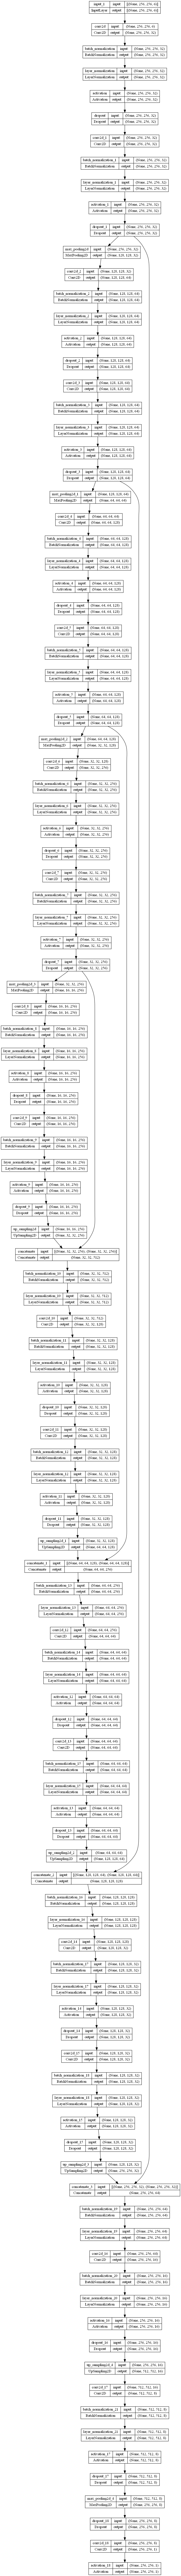

In [11]:
utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
model.load_weights(this_weight_fn)

## Prepare Data And Calculate

### Load File Names

In [13]:
def read_single_data(file_middle):
    X1 = np.load(data_path + file_middle + '.npy')[4]
    X2 = np.load(data_path + 'Interpolated/' + file_middle + '.npy')
    y = np.load(data_path + file_middle + '_GroundTruth.npy')
    X = np.concatenate([X1, X2], axis = -1)
    return X, y

In [14]:
def read_many_data(middle_list):
    Xs = []
    ys = []
    for middle in tqdm(middle_list):
        try:
            X, y = read_single_data(middle)
            Xs.append(X)
            ys.append(y)
        except:
            print(f'Some problem(s) occurred while loading {middle}')
            pass
    return np.array(Xs), np.array(ys)

In [15]:
middle_list = {}
fold_nums = [*range(10)]
for fold_num in fold_nums:
    with open(f'fold_{fold_num:02d}.txt', 'r') as f:
        filenames = f.readlines()

    middle_list[fold_num] = ['train_' + filenames[i].split('/')[2][0:-1] for i in range(len(filenames))]

In [16]:
def get_final_pred_from_middles(middles, model):
    Xs, ys = read_many_data(middles)
    y_pred = model.predict(Xs)
    return y_pred, Xs, ys

In [17]:
def Dice_for_ndarray(y_true, y_pred):
    epsilon = 1e-10
    
    tp = np.mean(y_true * y_pred)
    fp = np.mean(y_pred) - tp
    fn = np.mean(y_true) - tp
    Dice = 2*tp / (2*tp + fp + fn + epsilon)
    return Dice

In [18]:
def dicees_from_false_color(y_preds, Y, thresholds=[0.5, 0.5, 0.5]):
    y_3 = np.zeros((*y_preds.shape[0:3], 3))
    for i in tqdm(range(3)):
        this_t = thresholds[i]
        this_y = y_preds[:,:,:,i] * 1.0
        this_y[np.where(this_y >= this_t)] = 1
        this_y[np.where(this_y < this_t)] = 0
        y_3[...,i] = this_y
    
    y_e = np.mean(y_3, axis=-1)
    y_e[np.where(y_e>=0.5)] = 1
    y_e[np.where(y_e<0.5)] = 0
    
    dicese = []
    Y = Y.reshape(y_3[...,0].shape)
    for i in range(3):
        dicese.append(Dice_for_ndarray(Y, y_3[...,i]))
    
    dicese.append(Dice_for_ndarray(Y, y_e))
    return dicese

In [26]:
def y_binarization(y, threshold):
    new_y = y * 0
    new_y[y >= threshold] = 1
    return new_y

def threholded_Dice(y_val, y_pred, threshold):
    this_y_pred = y_binarization(y_pred, threshold)
    Dice = Dice_for_ndarray(y_val, this_y_pred)
    
    return Dice

def dicees_from_two_type_false_color(y_preds, Y, secondary_weight=0.3, threshold=None):
    ws = [1, 1, 0.9, secondary_weight, secondary_weight, secondary_weight*0.9]
    ws = ws / np.sum(ws)
    
    y_pred = np.zeros((*y_preds.shape[0:-1], 1))
    for i in range(y_preds.shape[-1]):
        y_pred += y_preds[...,i].reshape((*y_preds.shape[0:-1], 1)) * ws[i]

    if threshold is None:
        best_threshold, best_val_Dice, averaged_val_Dice, Dice_after_threshold, thresholds = find_best_threshold_from_ypred(y_pred, Y)
        return best_threshold, best_val_Dice, (thresholds, Dice_after_threshold)

    Dice = threholded_Dice(Y, y_pred, threshold)
    return Dice

In [20]:
backbone_list = ['ResNet101V2', 'DenseNet201', 'VGG16']
thresholds = [0.5] * len(backbone_list)

In [32]:
results = pd.DataFrame({'Fold_Num': [],
                        'Dice A': [],
                        'Dice B': [],
                        'Dice C': [],
                        'Dice 3 Ensemble': [],
                        'Dice 6 Ensemble': [],
                        'Dice Final': []})

#for fold_num in fold_nums:
for fold_num in range(1, 10):
    print(f'Fold {fold_num}')
    final_y_pred, Xs, ys = get_final_pred_from_middles(
        middle_list[fold_num], model)
    dicese = dicees_from_false_color(Xs, ys, thresholds=thresholds)
    model_dice = Dice_for_ndarray(ys, final_y_pred)
    six_mean_dice = dicees_from_two_type_false_color(Xs, ys, secondary_weight=0.2, threshold=0.42)
    print([fold_num, *dicese, six_mean_dice, model_dice])
    results.loc[len(results)] = [fold_num, *dicese, six_mean_dice, model_dice]

Fold 1


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:58<00:00,  5.73it/s]


65/65 [==============================] - 22s 340ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.77s/it]


[1, 0.6524535199196702, 0.578125944957671, 0.5533759944431569, 0.6181377937391533, 0.626239818105164, 0.6019174802885982]
Fold 2


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:48<00:00,  5.89it/s]


65/65 [==============================] - 11s 177ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.13s/it]


[2, 0.5789925039841272, 0.6583222303370962, 0.562351698061624, 0.624617883383528, 0.6298322788363883, 0.6035693872769612]
Fold 3


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:20<00:00,  6.40it/s]


65/65 [==============================] - 12s 179ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.33s/it]


[3, 0.5819130136406807, 0.5875003565010144, 0.5632173389740529, 0.6026970843258016, 0.6087074992720823, 0.5837103913476102]
Fold 4


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:21<00:00,  6.38it/s]


65/65 [==============================] - 11s 178ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.98s/it]


[4, 0.5798163904038267, 0.5874293249695378, 0.5623640116927509, 0.6022073319551364, 0.6084318820753041, 0.5879781017588728]
Fold 5


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:44<00:00,  5.97it/s]


65/65 [==============================] - 11s 176ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.28s/it]


[5, 0.5787716244739614, 0.586755939414363, 0.5600660146157631, 0.6003474987656484, 0.6061752057688454, 0.5816581620653913]
Fold 6


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:44<00:00,  5.97it/s]


65/65 [==============================] - 11s 176ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.05s/it]


[6, 0.5759988128180136, 0.5852530418628731, 0.5611394367509961, 0.5982694166561423, 0.6045710287917913, 0.5803439064265008]
Fold 7


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:51<00:00,  5.85it/s]


65/65 [==============================] - 11s 178ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.77s/it]


[7, 0.5787083636266086, 0.5824266087370107, 0.5548475359466631, 0.5982282765510042, 0.6050645659429675, 0.5803039736971843]
Fold 8


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:52<00:00,  5.83it/s]


65/65 [==============================] - 12s 180ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.98s/it]


[8, 0.5762804543897972, 0.5828449210072141, 0.5565197522977517, 0.5972680061397885, 0.6027641658234447, 0.57838968717378]
Fold 9


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [05:46<00:00,  5.93it/s]


65/65 [==============================] - 12s 179ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.76s/it]


[9, 0.5746820294838489, 0.5784733304083223, 0.5545896160101469, 0.593752678053449, 0.6002892991838558, 0.5757269548988101]


In [33]:
results

,Fold_Num,Dice A,Dice B,Dice C,Dice 3 Ensemble,Dice 6 Ensemble,Dice Final
0,1.0,0.652454,0.578126,0.553376,0.618138,0.626240,0.601917
1,2.0,0.578993,0.658322,0.562352,0.624618,0.629832,0.603569
2,3.0,0.581913,0.587500,0.563217,0.602697,0.608707,0.583710
3,4.0,0.579816,0.587429,0.562364,0.602207,0.608432,0.587978
4,5.0,0.578772,0.586756,0.560066,0.600347,0.606175,0.581658
5,6.0,0.575999,0.585253,0.561139,0.598269,0.604571,0.580344
6,7.0,0.578708,0.582427,0.554848,0.598228,0.605065,0.580304
7,8.0,0.576280,0.582845,0.556520,0.597268,0.602764,0.578390
8,9.0,0.574682,0.578473,0.554590,0.593753,0.600289,0.575727


In [37]:
mean_dices = {'Dice A': None,
              'Dice B': None,
              'Dice C': None,
              'Dice 3 Ensemble': None,
              'Dice 6 Ensemble': None,
              'Dice Final': None}

for key in mean_dices.keys():
    mean_dices[key] = np.mean(results[results['Fold_Num']>=5][key])

In [40]:
std_dices = {'Dice A': None,
             'Dice B': None,
             'Dice C': None,
             'Dice 3 Ensemble': None,
             'Dice 6 Ensemble': None,
             'Dice Final': None}

for key in mean_dices.keys():
    std_dices[key] = np.std(results[results['Fold_Num']>=5][key])

In [38]:
mean_dices

{'Dice A': 0.5768882569584459,
 'Dice B': 0.5831507682859567,
 'Dice C': 0.5574324711242642,
 'Dice 3 Ensemble': 0.5975731752332065,
 'Dice 6 Ensemble': 0.6037728531021809,
 'Dice Final': 0.5792845368523334}

In [41]:
std_dices

{'Dice A': 0.001605480363820184,
 'Dice B': 0.0028253561816758014,
 'Dice C': 0.002693470482775731,
 'Dice 3 Ensemble': 0.00215870830796407,
 'Dice 6 Ensemble': 0.002060558310639659,
 'Dice Final': 0.0020616865586513076}